In [1]:
from itertools import chain

import numpy as np
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

mpl.use('pgf')

import seaborn as sns
sns.set_style('whitegrid')

def figsize(scale):
    fig_width_pt = 397.4849                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [2*fig_width,1.1*fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.titlesize": 16,
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "text.fontsize": 10,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

/Users/cogswell/envs/base_venv/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import os.path as pth
import re
from itertools import product
import numpy as np
#import caffe
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
#import gpu_lock
from IPython.display import Image, display, HTML
#from cogswell.caffe_helper import jinja_render
#import caffe.proto.caffe_pb2 as cpb

from ipyparallel import Client

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline
#plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'
#plt.rcParams['axes.grid'] = False

from pdb import set_trace

In [3]:
df = pd.DataFrame.from_csv('decornet results (alexnet + others) - re-tune.csv', index_col=None)

In [4]:
df

metric           xcov dropout    128     160     192     224     256  \
0   top1             no      no  95.72   98.92   99.38   99.47   99.49   
1   top1             no     yes  57.12   65.83   71.02   75.53   79.08   
2   top1  yes (fc6+fc7)      no  60.56   72.87   79.20   80.75   78.24   
3   top1  yes (fc6+fc7)     yes  51.95   59.72   65.34   69.77   74.25   
4   top5             no      no  99.83  100.00  100.00  100.00  100.00   
5   top5             no     yes  79.89   86.18   89.37   91.94   93.72   
6   top5  yes (fc6+fc7)      no  82.63   90.77   94.19   94.96   93.94   
7   top5  yes (fc6+fc7)     yes  75.99   82.22   86.16   89.03   91.62   

   Unnamed: 8  128.1  160.1  192.1  224.1  256.1  Unnamed: 14  128.2  160.2  \
0         NaN  36.36  41.09  43.67  45.07  45.98          NaN  59.36  57.83   
1         NaN  45.13  50.88  53.54  55.78  56.87          NaN  11.99  14.95   
2         NaN  45.86  49.67  51.33  51.76  51.92          NaN  14.70  23.20   
3         NaN  43.55  49.05  52.20  54.06  55.77          NaN   8.40  10.67   
4         NaN  58.38  63.56  66.43  67.76  68.81          NaN  41.45  36.44   
5         NaN  69.67  74.89  77.20  79.12  80.02          NaN  10.22  11.29   
6         NaN  70.22  73.73  74.97  75.52  75.46          NaN  12.41  17.04   
7         NaN  68.39  73.69  76.30  77.92  79.47          NaN   7.60   8.53   

   192.2  224.2  256.2  
0  55.71  54.40  53.51  
1  17.48  19.75  22.21  
2  27.87  28.99  26.32  
3  13.14  15.71  18.48  
4  33.57  32.24  31.19  
5  12.17  12.82  13.70  
6  19.22  19.44  18.48  
7   9.86  11.11  12.15

In [5]:
def get_data(metric, xcov, dropout, train_val_gap=False):
    x = [128, 160, 192, 224, 256]
    metric_i = df.columns.get_loc('metric')
    xcov_i = df.columns.get_loc('xcov')
    dropout_i = df.columns.get_loc('dropout')
    train_start = df.columns.get_loc('128')
    train_end = df.columns.get_loc('256')
    val_start = df.columns.get_loc('128.1')
    val_end = df.columns.get_loc('256.1')
    gap_start = df.columns.get_loc('128.2')
    gap_end = df.columns.get_loc('256.2')
    for row in df.itertuples(index=False):
        #print row[metric_i], row[xcov_i], row[dropout_i]
        #print row[metric_i] == metric
        #print xcov in row[xcov_i]
        #print dropout in row[dropout_i]
        if (row[metric_i] == metric and
           xcov in row[xcov_i] and
           dropout in row[dropout_i]):
            if train_val_gap:
                return (x, row[gap_start:gap_end+1])
            else:
                return (x, row[train_start:train_end+1], row[val_start:val_end+1])
    else:
        raise Exception('no such data')

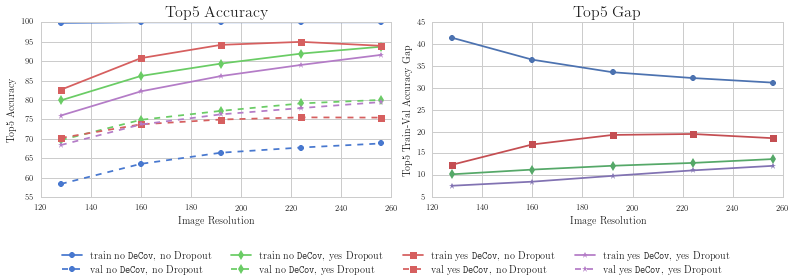

In [8]:
fig = plt.figure(figsize=figsize(scale=1.0))
colors = sns.color_palette('muted', 4)
markers = ['8', 'd', 's', '*']

# use 'top1' for top of figure 5
# use 'top5' for bottom of figure 5
metric = 'top5'

train_labels = []
train_lines = []
val_labels = []
val_lines = []

plt.subplot(121)
for i, tup in enumerate([('no', 'no'), ('no', 'yes'), ('yes', 'no'), ('yes', 'yes')]):
    xcov, dropout = tup
    x, y_train, y_val = get_data(metric, xcov, dropout)
    label = 'train {} \\texttt{{DeCov}}, {} Dropout'.format(xcov, dropout)
    l = plt.plot(x, y_train, '-', color=colors[i], marker=markers[i], label=label)
    train_lines.append(l[0])
    train_labels.append(label)
    label = 'val {} \\texttt{{DeCov}}, {} Dropout'.format(xcov, dropout)
    l = plt.plot(x, y_val, '--', color=colors[i], marker=markers[i], label=label)
    val_lines.append(l[0])
    val_labels.append(label)
plt.xlabel('Image Resolution')
plt.ylabel('{metric} Accuracy'.format(metric=metric.title()))
plt.title('{metric} Accuracy'.format(metric=metric.title()))

    
plt.subplot(122)
for i, tup in enumerate([('no', 'no'), ('no', 'yes'), ('yes', 'no'), ('yes', 'yes')]):
    xcov, dropout = tup
    x, y_gap = get_data(metric, xcov, dropout, train_val_gap=True)
    l = plt.plot(x, y_gap, marker=markers[i], label='{} \\texttt{{DeCov}}, {} Dropout'.format(xcov, dropout))

plt.xlabel('Image Resolution')
plt.ylabel('{metric} Train-Val Accuracy Gap'.format(metric=metric.title()))

lines = list(chain(*zip(train_lines, val_lines)))
labels = list(chain(*zip(train_labels, val_labels)))
if metric == 'top5':
    fig.legend(lines, labels, 'lower center', bbox_to_anchor=(0.5, -0.02), ncol=4)
plt.title('{metric} Gap'.format(metric=metric.title()))
if metric == 'top5':
    plt.tight_layout(pad=0.5, rect=(0, 0.15, 1, 1))
else:
    plt.tight_layout(pad=0.5)
plt.savefig('{}_plot.pdf'.format(metric))